In [1]:
# Battery Storage Model

In [2]:
# Import Libraries
import sys, os
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.bess import simulate_bess_dispatch, summarize_bess, visualize_bess, run_bess_model
from src.report_utils import save_dataframe, save_figure
from src.config_loader import load_config

cfg = load_config()

OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:
# Load Price Data
prices = pd.read_csv(os.path.join(OUTPUT_DIR, "lbmp_zoneA_cleaned.csv"),
                     index_col=0, parse_dates=True)

prices.index = pd.to_datetime(prices.index, errors="coerce", utc=True)
prices = prices.loc[prices.index.notnull()]
prices = prices[~prices.index.duplicated(keep="first")]
prices = prices.sort_index()

print("Prices rows after sanitize:", len(prices))
print("Duplicates remaining:", prices.index.duplicated().sum())
print("Index range:", prices.index.min(), "→", prices.index.max())

Prices rows after sanitize: 8784
Duplicates remaining: 0
Index range: 2024-01-01 05:00:00+00:00 → 2025-01-01 04:00:00+00:00


In [4]:
assert len(prices) in (8760, 8784), "Unexpected number of hourly price rows."

Hours in series: 8784


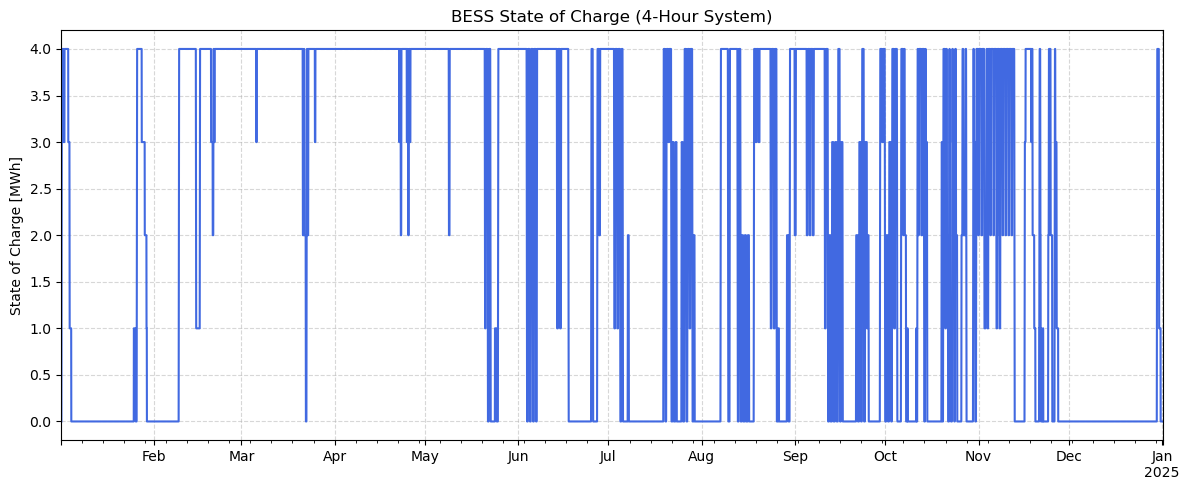

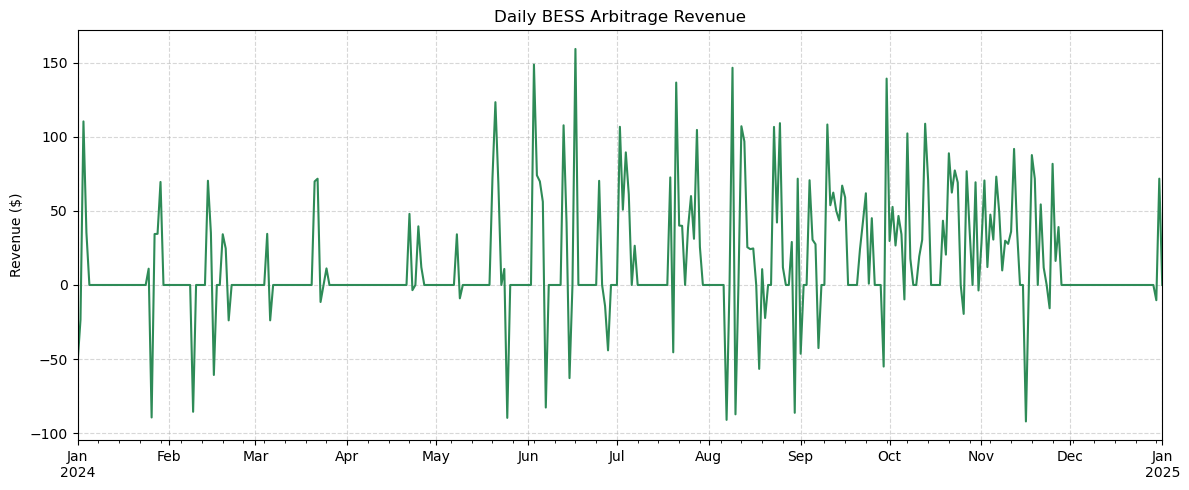

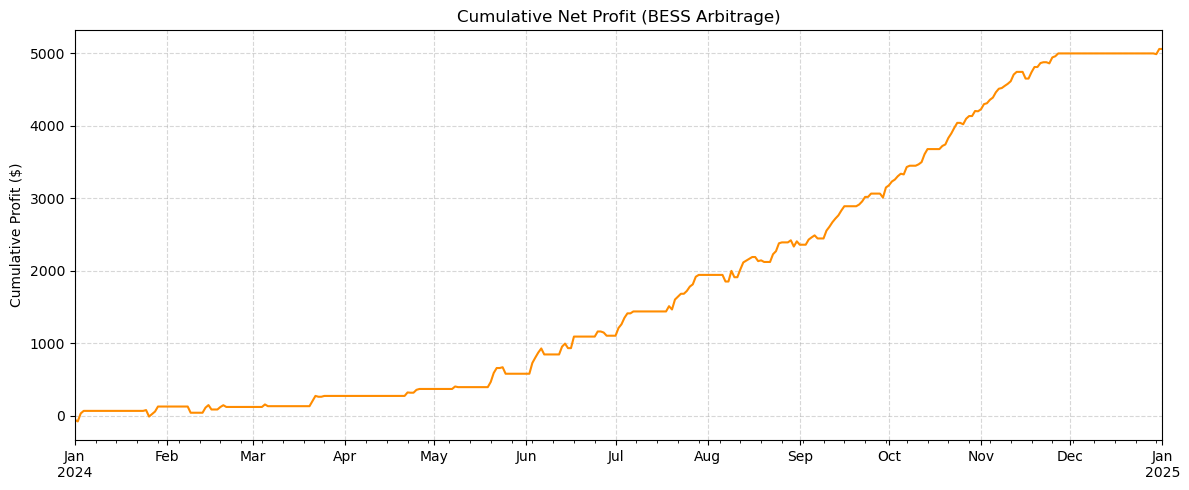

Saved DataFrame → bess_hourly_results.csv

BESS simulation complete.
————————————————————————————————————————
Total Net Revenue ($): 5,059.15
Estimated Full Cycles: 81.25
Average SOC (MWh): 2.16
Days Active: 127.0
Avg Daily Net Revenue ($/day): 39.84
BESS rows: 8784


In [5]:
# Choose pricing model
USE_RTD = False                # True =  real-time prices, False = day-ahead prices
USE_DAILY_THRESHOLDS = False   # True = daily thresholds, False = annual quantiles

series = prices["RTD_LBMP" if USE_RTD else "DAM_LBMP"].copy()

bess_df, bess_summary = run_bess_model(series, output_dir=OUTPUT_DIR)
print("BESS rows:", len(bess_df))  # should match prices length (8760 or 8784)

In [6]:
bess_df.to_csv(os.path.join(OUTPUT_DIR, "bess_dispatch_results.csv"))

In [7]:
# Sanity checks
print("\nSanity checks:")
print("Net revenue 1st 24h ($):", round(bess_df["net_revenue_$"].head(24).sum(), 2))
print("Total net revenue ($):", round(bess_df["net_revenue_$"].sum(), 2))
print("Avg SOC (MWh):", round(bess_df["SOC_MWh"].mean(), 3))
print("Max SOC (MWh):", round(bess_df["SOC_MWh"].max(), 3))


Sanity checks:
Net revenue 1st 24h ($): -53.07
Total net revenue ($): 5059.15
Avg SOC (MWh): 2.164
Max SOC (MWh): 4.0


In [8]:
daily = bess_df["net_revenue_$"].resample("D").sum()
monthly = bess_df["net_revenue_$"].resample("ME").sum()

daily.to_csv(os.path.join(OUTPUT_DIR, "bess_daily_net_revenue.csv"))
monthly.to_csv(os.path.join(OUTPUT_DIR, "bess_monthly_net_revenue.csv"))

Hours in series: 8784


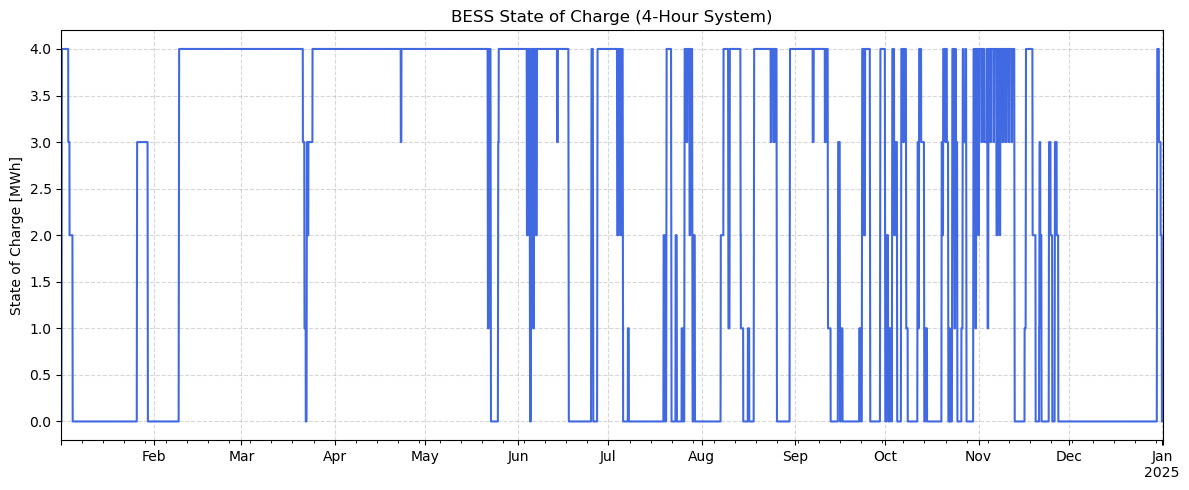

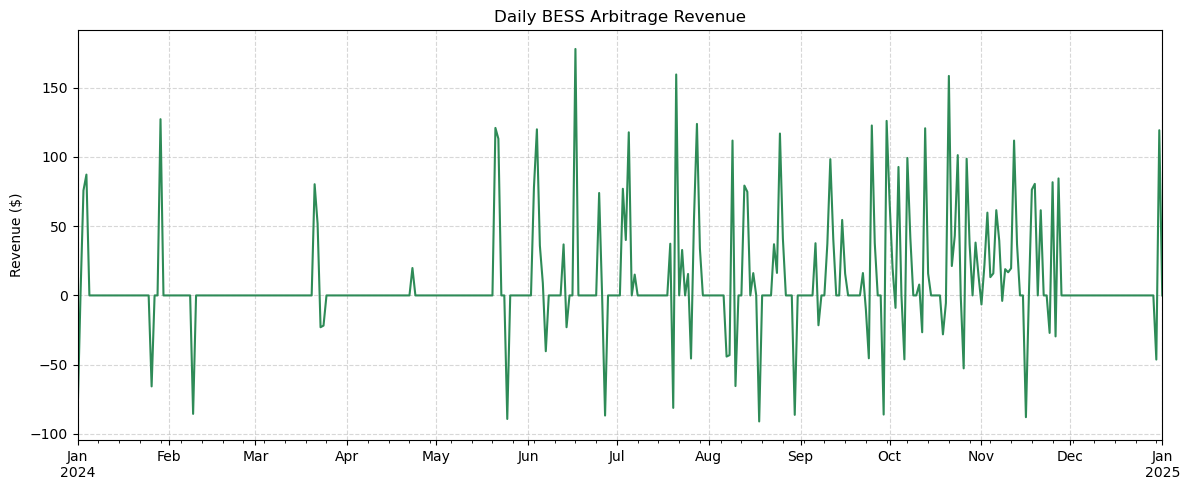

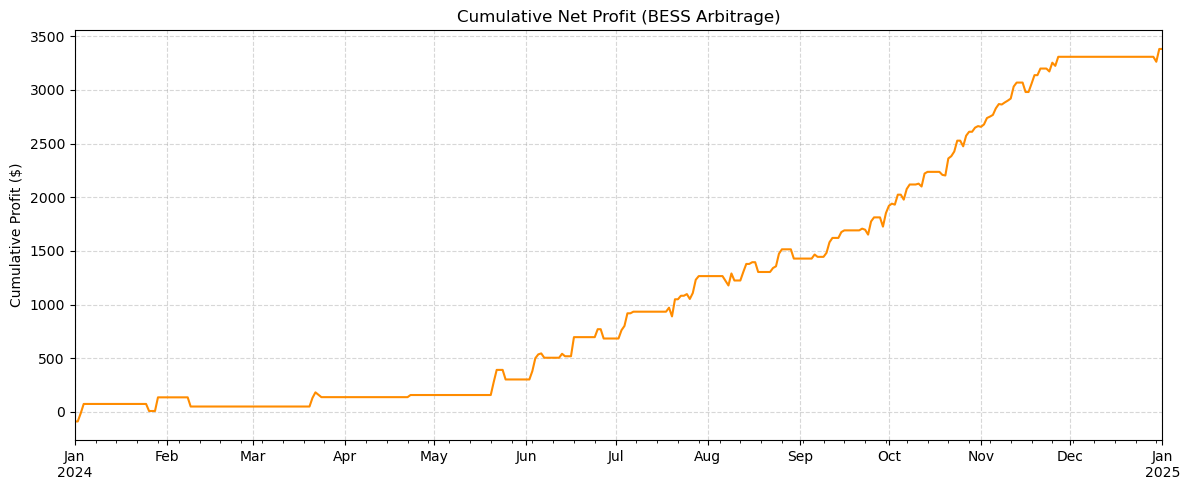

Saved DataFrame → bess_hourly_results.csv

BESS simulation complete.
————————————————————————————————————————
Total Net Revenue ($): 3,382.16
Estimated Full Cycles: 45.5
Average SOC (MWh): 2.21
Days Active: 90.0
Avg Daily Net Revenue ($/day): 37.58
Hours in series: 8784


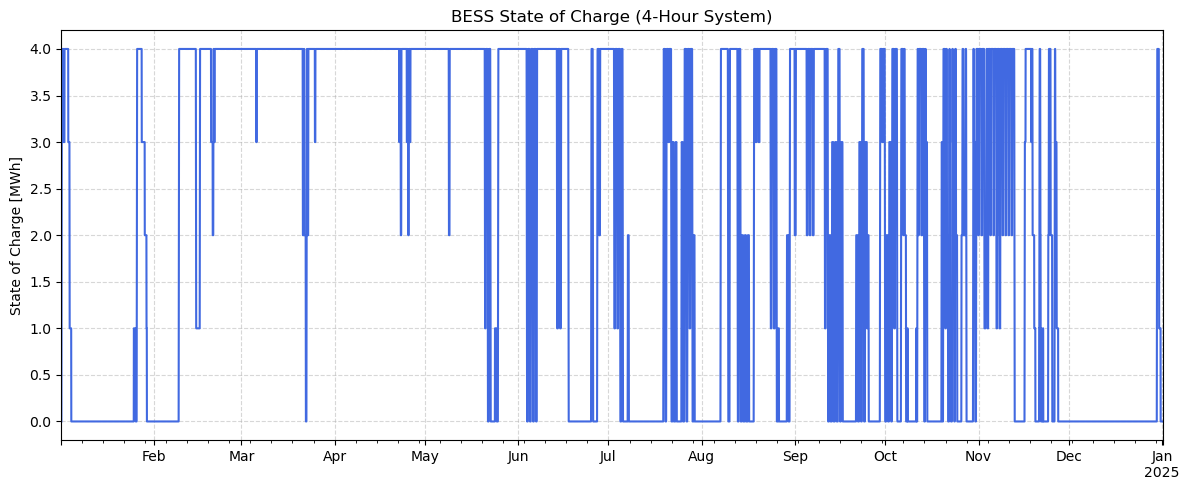

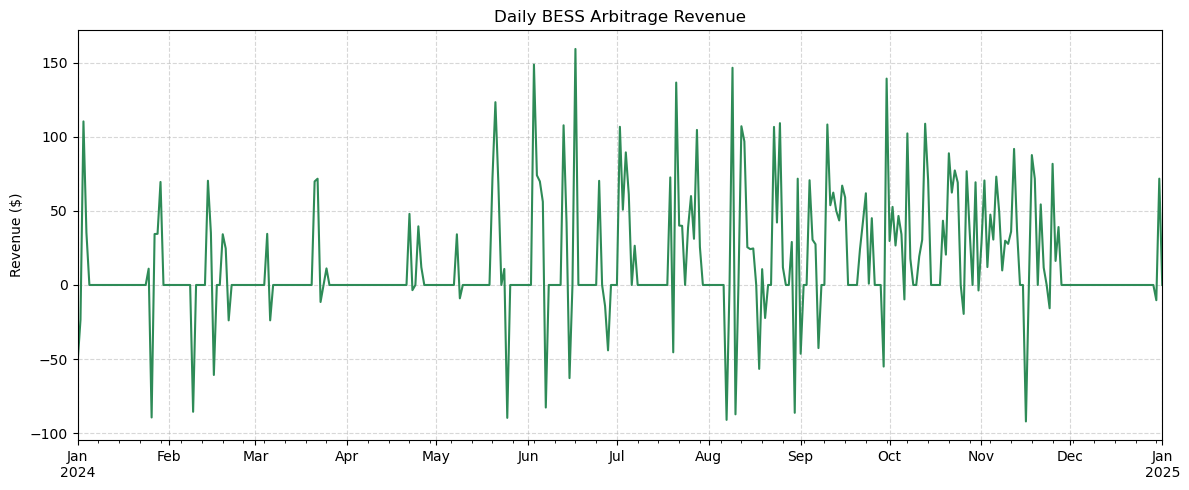

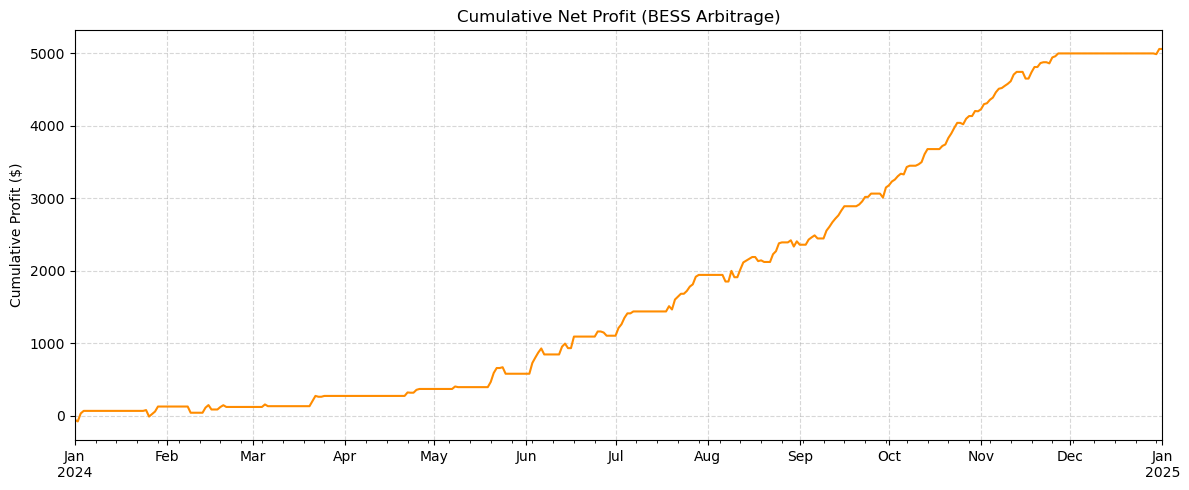

Saved DataFrame → bess_hourly_results.csv

BESS simulation complete.
————————————————————————————————————————
Total Net Revenue ($): 5,059.15
Estimated Full Cycles: 81.25
Average SOC (MWh): 2.16
Days Active: 127.0
Avg Daily Net Revenue ($/day): 39.84
Hours in series: 8784


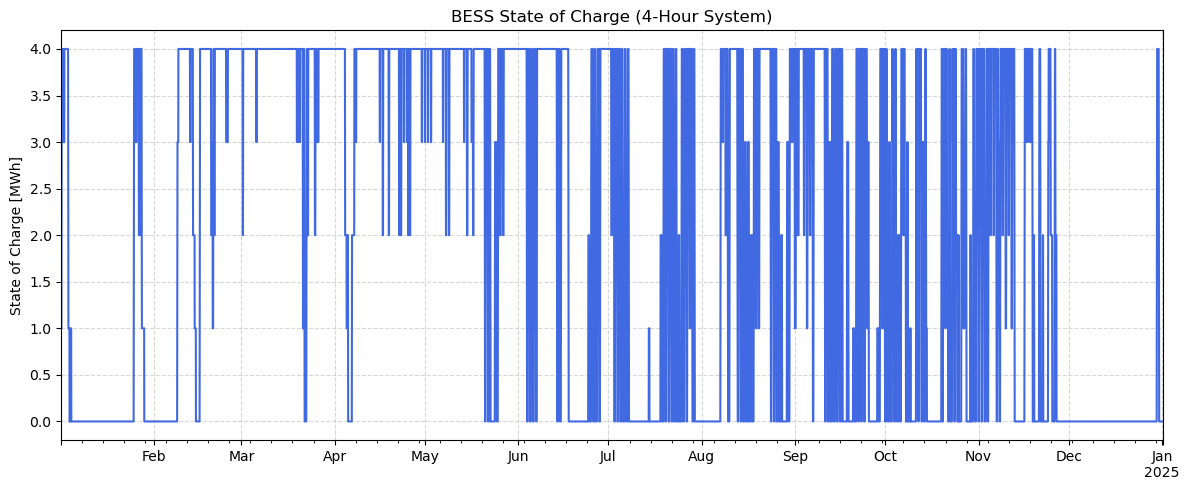

In [ ]:
# Sensitivity Checks for low charge/high charge distribution
tests = []
for lq, hq in [(0.20,0.80), (0.25,0.75), (0.30,0.70)]:
    tmp_df, tmp_sum = run_bess_model(
        series,
        output_dir=OUTPUT_DIR,
        use_daily_thresholds=False,
        low_q=lq, high_q=hq
    )
    tests.append({"low_q": lq, "high_q": hq, "Total Net Revenue ($)": tmp_sum["Total Net Revenue ($)"]})

sens_df = pd.DataFrame(tests)
sens_df